#**주택 가격 (House Prices) 예측 : Advanced**

https://www.kaggle.com/code/subinium/subinium-tutorial-house-prices-advanced

###Content

**Part 1 : 라이브러리, 데이터 확인하기**

**Part 2 : Data Processing**
   - GrLivArea 피처의 이상치 제거
   - SalePrice 타겟 변수의 로그변환

**Part 3 : Feature Engineering**
   - Inputing missing values
   - Transforming : 숫자형이지만 범주형인 피처들을 str형태로 변환
   - Label Encoding : 범주형 피처를 서수형으로 변환
   - Adding new important feature
   - Box Cox Transformation : 왜곡된 피처들을 정규분포 형태로 변환
   - Getting dummy variables : 범주형 피처들을 원-핫 인코딩

**Part 4 : Modeling**
   - Base Models
   - Stacking Models
      - Average base models
      - Adding a meta model
   - Ensembling Models


##Part 1 : 라이브러리, 데이터 확인하기


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')   # warnings 무시
%matplotlib inline

# Set theme for sns
sns.set_style('darkgrid')

# 소숫점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

# 디렉토리 내, 사용가능 파일 체크
from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/ESAA_YB/Datasets/house_price"]).decode("utf8"))

house_price_test.csv
house_price_train.csv



In [3]:
# Read the data
train_df = pd.read_csv('/content/drive/MyDrive/ESAA_YB/Datasets/house_price/house_price_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ESAA_YB/Datasets/house_price/house_price_test.csv')

In [4]:
# Check the data
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Drop the 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

##Part 2 : Data Processing

####**GrLivArea 피처의 이상치 제거**

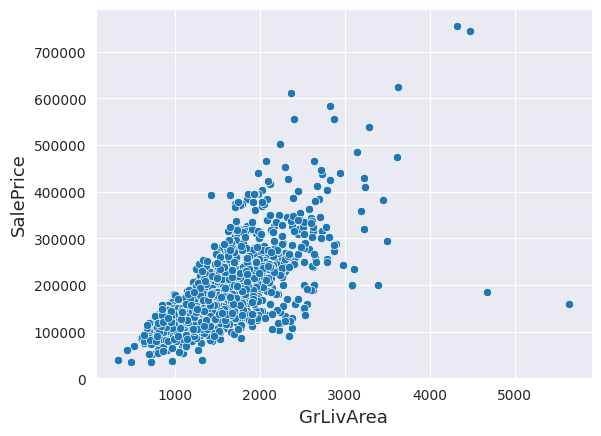

In [7]:
# Scatterplot between GrLivArea and SalePrice
# GrLivArea는 크지만 SalePrice는 작은 두 개의 이상치가 보임.
fig, ax = plt.subplots()
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

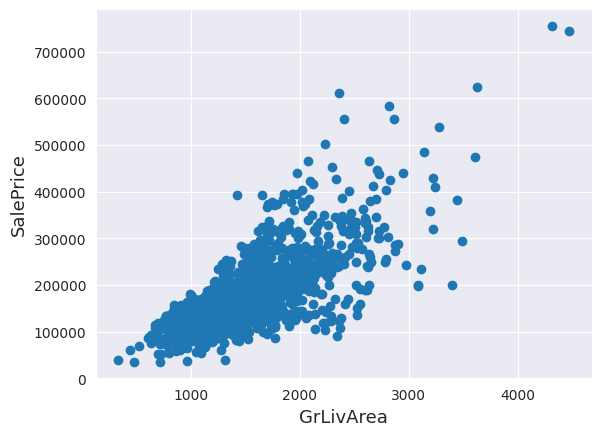

In [8]:
# Delete the two outliers of GrLivArea
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# Check the graph again
fig, ax = plt.subplots()
ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

####**SalePrice 타겟 변수의 로그변환**

180932.91906721535 79467.78892987774


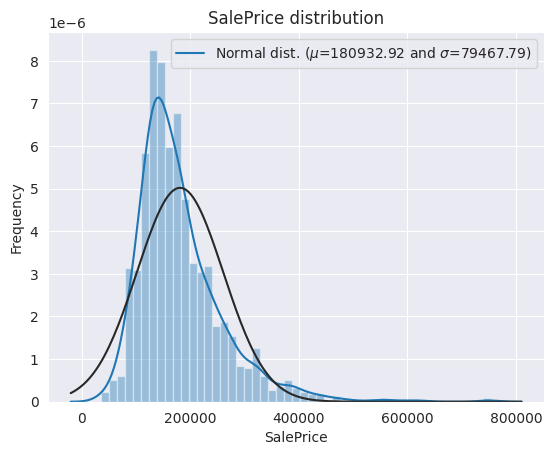

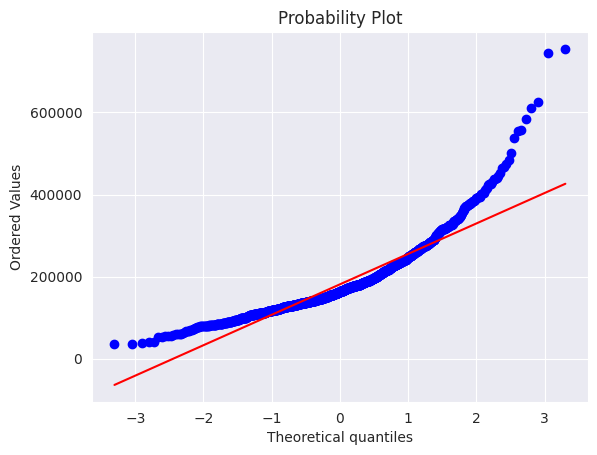

In [9]:
# SalePrice의 분포가 정규분포와 얼마나 부합하는지 확인하기
# 분포가 오른쪽으로 치우침.

sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# Plot the distribution as a graph
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Q-Q plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

12.024015155682552 0.3995757283645756


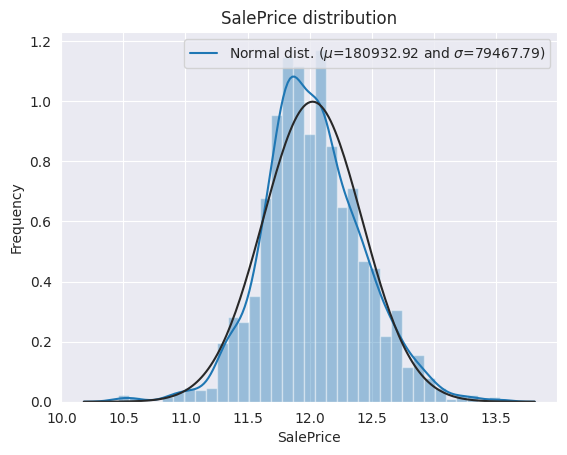

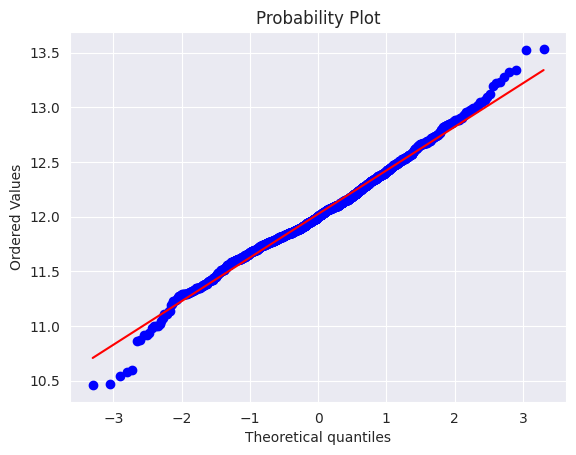

In [10]:
# np.log1p를 이용해 칼럼의 모든 원소에 log(1+x)함수를 적용하여 로그변환하기
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 분포 재확인하기
# 분포가 정규분포에 매우 근접하게 바뀜.
sns.distplot(train_df['SalePrice'], fit=norm)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

## Part 3 : Feature Engineering


In [11]:
# 데이터를 하나로 묶어서 사용하기 위해서 하나로 묶기
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)   # 기존 인덱스를 삭제하고 새로운 기본 인덱스 생성
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


**null 값 비율 확인하기**

In [12]:
# null값이 존재하는 칼럼의 null값 비율 확인하기
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


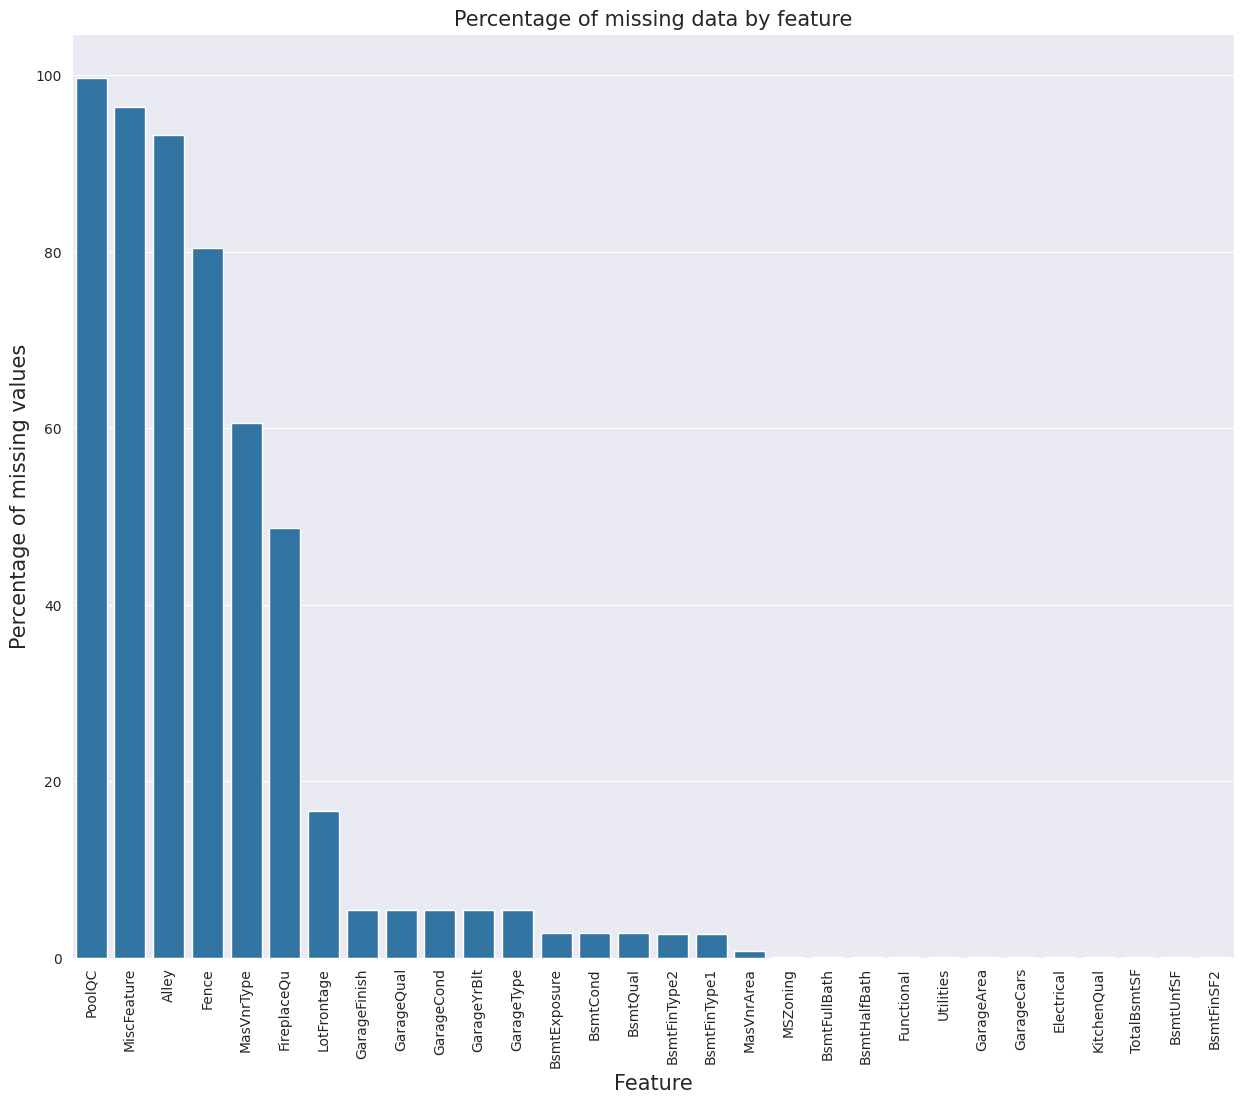

In [13]:
# null값이 존재하는 칼럼의 null값 비율 시각화하기
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na.values)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data by feature', fontsize=15)
plt.show()

**Heatmap으로 피처들 간 관계 파악하기**

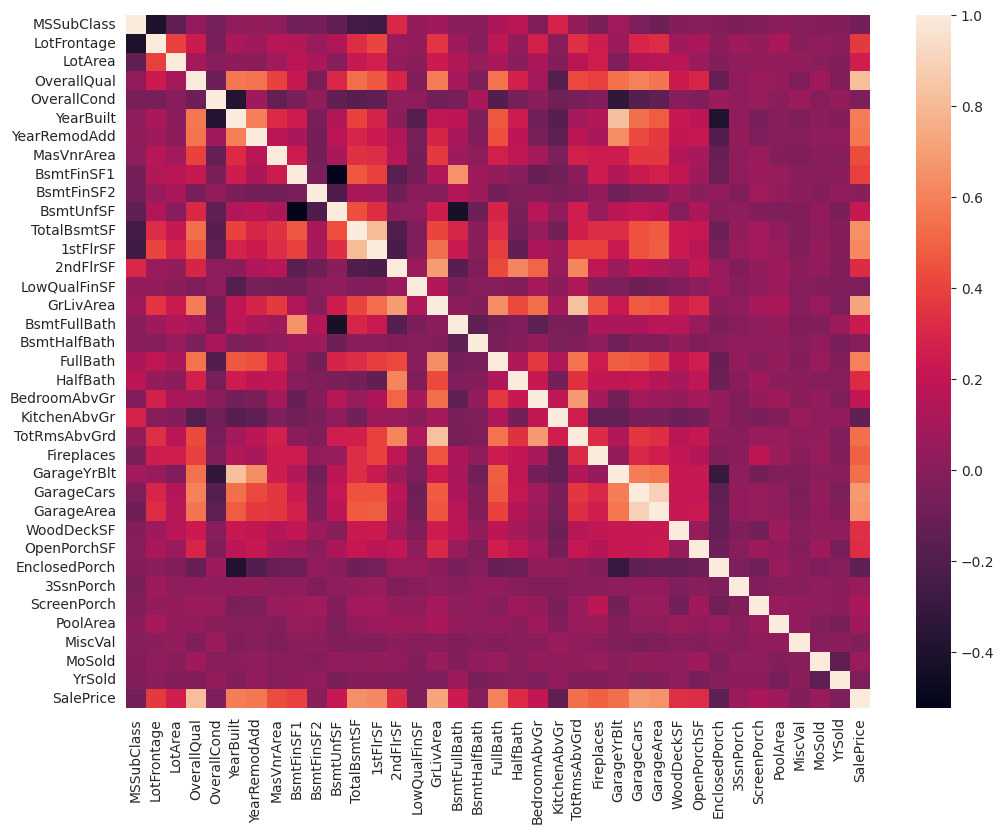

In [14]:
# Heatmap으로 타겟변수인 SalePrice와 다른 (숫자형) 피처들 간 관계 확인하기
train_numeric_df = train_df.select_dtypes(include=['number'])
corrmat = train_numeric_df.corr()

plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat)
plt.show()

####**Inputing missing values**

- **LotFrontage** : 거리 요소, 이웃들의 거리와 유사한 값을 가질 것임. NA값을 해당하는 동네의 중앙값으로 채우기.
- **Utilities** : 피처의 모든 값이 'AllPub'으로 되어있고, 한 개가 'NoSeWa', 두 개가 NaN값임. 극단적인 분포로 예측에 유용하지 않을 듯 하니 그냥 drop하기.
- **PoolQC** : NA값은 'No Pool'을 의미한다고 명시되어 있음. 99%의 NA값을 'None'으로 채우기.
- **Functional** : NA는 typical을 의미한다고 명시되어있음. 빈 값을 'Typ'으로 채우기
- 나머지 숫자형 피처의 NA값은 0으로 대체
- 나머지 범주형 피처의 NA값은 'None' 또는 최빈값으로 대체 (왜 어떤건 None으로 대체하고 어떤건 최빈값으로 대체할까?)


In [ ]:
# 'None'으로 채우기
for col in ('MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

In [ ]:
# 0으로 채우기
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
  all_data[col] = all_data[col].fillna(0)

In [ ]:
# 최빈값으로 채우기
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
  # all_data[col].mode()는 Series 타입임. mode값만 추출하려면 all_data[col].mode()[0].
  all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
# LotFrontage : 거리 요소, 이웃들의 거리와 유사한 값을 가질 것임. NA값을 해당하는 동네의 중앙값으로 채우기.
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [22]:
# Utilities 피처의 분포 살피기. Utilities 피처의 모든 값이 'AllPub'으로 되어있고, 한 개가 'NoSeWa', 두 개가 NaN값임.
all_data['Utilities'].value_counts(dropna=False)

,count
Utilities,
AllPub,2914
NaN,2
NoSeWa,1


In [23]:
# Utilities 피처는 극단적인 분포로 예측에 유용하지 않을 듯 하니 그냥 drop하기
all_data = all_data.drop(['Utilities'], axis=1)

In [15]:
# PoolQC : NA값은 'No Pool'을 의미한다고 명시되어 있음. 99%의 NA값을 'None'으로 채우기.
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [24]:
# Functional : NA는 typical을 의미한다고 명시되어있음. 빈 값을 'Typ'으로 채우기
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [25]:
# 채워지지 못한 데이터가 있는지 확인하기. 다 잘 채워짐.
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


####**Transforming**
- 숫자형이지만 범주형인 피처들을 str형태로 변환

In [30]:
# MSSubClass : the building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
# Change OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Change Year and Month sold into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

####**Label Encoding**
- 범주형 피처를 서수형으로 변환

In [81]:
from sklearn.preprocessing import LabelEncoder

cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold']

for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

In [32]:
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


####**Adding new important feature**
- 집의 가용 평수는 주택 가격에서 중요한 요소 중 하나
- 집의 가용 평수 = basement + 1층 + 2층공간으로 새로운 피처 생성하기

In [34]:
# 집의 가용 평수 = basement + 1층 + 2층공간으로 새로운 피처 생성하기
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['TotalSF'].head()

,TotalSF
0,2566.000
1,2524.000
2,2706.000
3,2473.000
4,3343.000


####**Box Cox Transformation**
- 왜곡된 피처들을 정규분포 형태로 변환
- 비대칭 분포 데이터에 대해 좀 더 좋은 결과(리더보드와 cross-validation에서)를 낼 수 있음
-
```
from scipy.special import boxcox1p
boxcox1p(data, lam = lambda)
```


In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# 수치형 피처들의 왜곡도(skewness) 확인
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print('\n Skew in numerical features:\n')
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)


 Skew in numerical features:



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [38]:
# 왜곡도가 심한 (0.75 이상인) 피처들을 Box-Cox Transformation 하기
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box-Cox Transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
  all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box-Cox Transform


####**Getting dummy variables**
- 범주형 피처들을 원-핫 인코딩

In [39]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [40]:
# 다시 train_df, test_df로 나누기
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

print(train_df.shape, test_df.shape)

(1458, 220) (1459, 220)


##Part 4 : Modeling

In [42]:
# Import libraries
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**평가 함수**
-  cross_val_score을 쓰되, 검증의 정확도를 높이기 위해 순서를 섞는 KFold 사용 (cross_val_score은 순서를 안섞음)
- RMSE값으로 평가

In [43]:
# Define validation function
n_folds = 5
def rmsle_cv(model):
  # get_n_splits() returns the number of folds (n_folds).
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
  rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train,
                                  scoring='neg_mean_squared_error', cv=kf))
  return rmse

####**Base models**
- Lasso, ElasticNet, KernelRidge, Gradient boosting, XGBoost, LightGBM
- Lasso, ElasticNet은 이상치에 민감하기 때문에 이상치를 규제하기 위해서 pipeline에 RobustScaler( ) 메서드 사용.
- make_pipeline( ) is a function that allows you to chain together multiple steps in a squential workflow.
- GradientBoostingRegressor( )의 파라미터 loss='huber'로 지정함으로써 이상치에 덜 민감한 손실함수 설정.

In [55]:
# Lasso, ElasticNet Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

In [56]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [57]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [59]:
# XGBoost (하이퍼 파라미터는 베이지안 최적화를 사용하여 설정)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640,
                             reg_lambda=0.857, subsample=0.5213, silent=1, random_state=7, nthread=-1)

In [62]:
# LightGBM
model_lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05,
                               n_estimators=720, max_bin=55, bagging_fraction=0.8, bagging_freq=5,
                               feature_fraction=0.2319, feature_fraction_seed=9,
                               bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11, verbose=-1)

In [63]:
score = rmsle_cv(lasso)
print('\n Lasso score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print('\n ElasticNet score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print('\n Kernel Ridge score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print('\n Gradient Boosting score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print('\n Xgboost score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))
score = rmsle_cv(model_lgbm)
print('\n LGBM score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))


 Lasso score: 0.1115 (std : 0.0074)


 ElasticNet score: 0.1116 (std : 0.0074)


 Kernel Ridge score: 0.1153 (std : 0.0075)


 Gradient Boosting score: 0.1167 (std : 0.0083)


 Xgboost score: 0.1167 (std : 0.0068)


 LGBM score: 0.1167 (std : 0.0059)



####**Stacking models**
- **Averaging base models**
   - ENet, GBoost, KRR, lasso
   - 제일 간단한 스태킹 기법
   - 1. Combine the predictions from base models using an aggregation method.
       - Averaging: Take the mean or weighted average of the predictions

     2. Then make final predictions using the aggregated outputs.
  
   - class를 만들어 캡슐화하여 재사용이 가능하도록 하기

In [66]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):

  def __init__(self, models):
    self.models = models

  # We define clones of the original models to fit the data in.
  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]
    # Train the cloned base models
    for model in self.models_:
      model.fit(X, y)
    return self

  # Now, we make predictions for the cloned models and average them.
  def predict(self, X):
    predictions = np.column_stack([
        model.predict(X) for model in self.models_])
    return np.mean(predictions, axis=1)

In [67]:
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print('Averaged base models score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))

Averaged base models score: 0.1087 (std : 0.0077)



- **Adding a Meta-model**
   - meta model: lasso
    
     base model: ENet, GBoost, KRR
     
   - meta model을 추가하고, base model들의 평균과 out-of-folds 예측을 이용해서 meta model을 훈련시키는 방법

   

In [68]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)

            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [69]:
stacked_averaged_models = StackingAveragedModels(
    base_models = (ENet, GBoost, KRR),
    meta_model = (lasso)
)

score = rmsle_cv(stacked_averaged_models)
print('Stacking averaged base models score: {:.4f} (std : {:.4f})\n'.format(score.mean(), score.std()))

Stacking averaged base models score: 0.1081 (std : 0.0073)



####**Ensembling models**
- StackedRegressor, XGBoost, LightGBM
- 예측성능을 기준으로 가중치를 두어 세 모델들의 예측치들을 결합

   - cross_val_score( ) 기준 성능들
      - StackedRegressor :  0.1081 -> 70%
      - XGBoost :  0.1167 -> 15%
      - LGBM : 0.1167 -> 15%
- train 데이터 기준 RMSLE score 확인

In [70]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

In [72]:
# StackedRegressor
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)

print('StackedRegressor RMSLE score on train data: ', round(rmsle(y_train, stacked_train_pred), 4))

StackedRegressor RMSLE score on train data:  0.0784


In [73]:
# XGBoost
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)

print('XGBoost RMSLE score on train data: ', round(rmsle(y_train, xgb_train_pred), 4))

XGBoost RMSLE score on train data:  0.0867


In [74]:
# LightGBM
model_lgbm.fit(train_df, y_train)
lgbm_train_pred = model_lgbm.predict(train_df)

print('LightGBM RMSLE score on train data: ', round(rmsle(y_train, lgbm_train_pred), 4))

LightGBM RMSLE score on train data:  0.0717


In [80]:
# Ensembled model
print('RMSLE score on train data: ')
print(round(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgbm_train_pred*0.15), 4))

RMSLE score on train data: 
0.0765


**최종 예측치 생성 및 제출**
- expm1 <-> log1p
- 로그변환된 test_df.values 기준으로 predict 이후, 다시 expm1를 적용하여 원래 스케일에 맞는 최종 예측치 생성

In [77]:
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
xgb_pred = np.expm1(model_xgb.predict(test_df))
lgbm_pred = np.expm1(model_lgbm.predict(test_df))

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgbm_pred*0.15

In [78]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)

In [79]:
sub.head()

,Id,SalePrice
0,1461,120538.201
1,1462,159273.004
2,1463,185580.717
3,1464,195834.332
4,1465,191175.870
